# Вторая часть проекта. Разработка модели

## 2. Выбор архитектуры модели. Тестирование для разных n

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from dataclasses import dataclass
from tqdm import tqdm
from itertools import product

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from graphs import KNN_Graph, Distance_Graph
from characteristics_applied import *
from visualisations import *
from metrics import *
from classifier import *

In [ ]:
n = 50

### Базовая модель (рюкзак с контролем ошибки I рода)

In [ ]:
def describe_model_quality(y_pred, y_test, title, info):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"-------------------{title}-------------------")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC AUC: {roc_auc}')

    if info['prediction_type'] == 'A_indicator':
        model = info['model']
        exp_points = info['exp_points']
        pareto_points = info['pareto_points']

        I_error = calc_I_error_clfr(model, exp_points)
        power = calc_power_clfr(model, pareto_points)

        print(f'Ошибка первого рода = {I_error}')
        print(f'Мощность = {power}')

In [ ]:
def fit_rucksack_model(n, observations_count=500):
    clfr = DistibutionClassifier(n=n, observations_count=observations_count)
    clfr_validator = DistibutionClassifier(n=n, observations_count=observations_count // 2)

    clfr.generate_important_chars_points()
    clfr_validator.generate_important_chars_points()

    clfr.fit(clfr_validator.exp_points, clfr_validator.pareto_points, verbose=True)

    clfr_tester = DistibutionClassifier(n=n, observations_count=200)
    clfr_tester.generate_important_chars_points()
    X_test, y_test = clfr_tester.get_points_dataset()

    y_pred = clfr.predict_items(X_test)
    describe_model_quality(y_pred, y_test, "Rucksack model metrics", {
        'prediction_type' : 'A_set',
        'A_set' : clfr.A,
        'tester' : clfr_tester
    })

Generating characteristics...


100%|██████████| 500/500 [00:01<00:00, 333.89it/s]



Characteristics generated!
Generating characteristics...


100%|██████████| 250/250 [00:00<00:00, 314.64it/s]



Characteristics generated!
Building A...


 83%|████████▎ | 74/89 [00:49<00:10,  1.48it/s]


A builded with power = 0.772, I_error = 0.048!


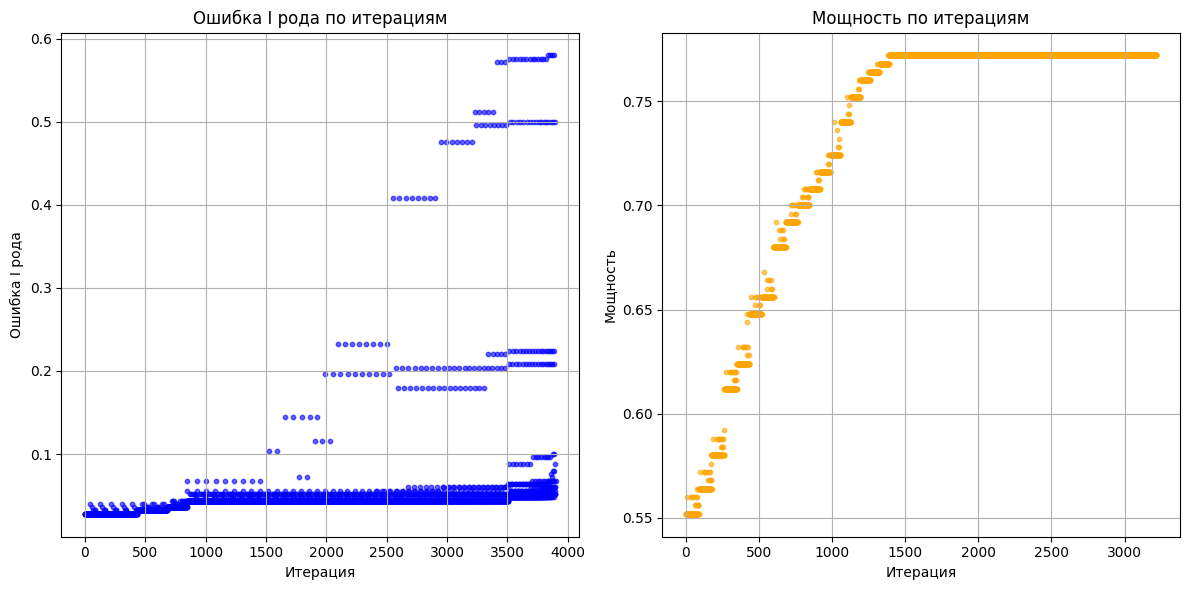

Generating characteristics...


100%|██████████| 200/200 [00:00<00:00, 334.43it/s]



Characteristics generated!
-------------------Rucksack model metrics-------------------
Accuracy: 0.8075
Precision: 0.8682634730538922
Recall: 0.725
F1 Score: 0.7901907356948229
ROC AUC: 0.8075


In [ ]:
fit_rucksack_model(n=50, observations_count=500)

### Случайный лес

In [ ]:
def pick_random_forest_model(X_train, y_train):
    n_estimators_variants = [5, 10, 50, 100]
    max_depth_variants = [None, 5, 10, 20, 40, 80, 160]
    min_samples_leaf_variants = [1, 2, 5, 10, 20]

    param_grid = {
        'n_estimators' : n_estimators_variants,
        'max_depth': max_depth_variants,
        'min_samples_leaf': min_samples_leaf_variants
    }
    model_random_forest = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=model_random_forest, param_grid=param_grid,
                            scoring='f1', cv=5, n_jobs=-1)

    grid_search.fit(X_train, y_train.to_numpy().flatten().ravel())
    return grid_search.best_estimator_

def fit_random_forest_model(n, observations_count=300):
    clfr = DistibutionClassifier(n=n, observations_count=observations_count)
    clfr.generate_important_chars_points()

    X_train, y_train = clfr.get_points_dataset()

    model = pick_random_forest_model(X_train, y_train)

    clfr_tester = DistibutionClassifier(n=n, observations_count=200)
    clfr_tester.generate_important_chars_points()
    X_test, y_test = clfr_tester.get_points_dataset()

    y_pred = model.predict(X_test)
    describe_model_quality(y_pred, y_test, "Random forest model metrics", {
        'prediction_type' : 'A_indicator',
        'model' : model,
        'exp_points' : clfr_tester.exp_points,
        'pareto_points' : clfr_tester.pareto_points
    })

In [ ]:
fit_random_forest_model(50, 700)

Generating characteristics...


100%|██████████| 700/700 [00:03<00:00, 210.42it/s]


Characteristics generated!


Generating characteristics...


100%|██████████| 200/200 [00:00<00:00, 333.84it/s]



Characteristics generated!
-------------------Random forest model metrics-------------------
Accuracy: 0.8525
Precision: 0.8341232227488151
Recall: 0.88
F1 Score: 0.8564476885644768
ROC AUC: 0.8524999999999999
Ошибка первого рода = 0.175
Мощность = 0.88


In [ ]:
fit_random_forest_model(100, 10)

Generating characteristics...


100%|██████████| 10/10 [00:00<00:00, 118.00it/s]



Characteristics generated!
Generating characteristics...


100%|██████████| 200/200 [00:01<00:00, 114.66it/s]



Characteristics generated!
-------------------Random forest model metrics-------------------
Accuracy: 0.96
Precision: 0.9339622641509434
Recall: 0.99
F1 Score: 0.9611650485436893
ROC AUC: 0.9599999999999999
Ошибка первого рода = 0.07
Мощность = 0.99


In [ ]:
fit_random_forest_model(500, 1500)

Generating characteristics...


100%|██████████| 1500/1500 [03:11<00:00,  7.82it/s]



Characteristics generated!
Generating characteristics...


100%|██████████| 200/200 [00:26<00:00,  7.58it/s]



Characteristics generated!
-------------------Random forest model metrics-------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Ошибка первого рода = 0.0
Мощность = 1.0


### Логистическая регрессия

In [ ]:
def fit_logistic_regression_model(n, observations_count=1000):
    clfr = DistibutionClassifier(n=n, observations_count=observations_count)
    clfr.generate_important_chars_points()
    X_train, y_train = clfr.get_points_dataset()

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression())
    ])
    model.fit(X_train, y_train.to_numpy().flatten().ravel())

    clfr_tester = DistibutionClassifier(n=n, observations_count=200)
    clfr_tester.generate_important_chars_points()
    X_test, y_test = clfr_tester.get_points_dataset()

    y_pred = model.predict(X_test)
    describe_model_quality(y_pred, y_test, "Logistic regression model metrics", {
        'prediction_type' : 'A_indicator',
        'model' : model,
        'exp_points' : clfr_tester.exp_points,
        'pareto_points' : clfr_tester.pareto_points
    })

In [ ]:
fit_logistic_regression_model(50, 700)

Generating characteristics...


100%|██████████| 700/700 [00:05<00:00, 132.75it/s]



Characteristics generated!
Generating characteristics...


100%|██████████| 200/200 [00:00<00:00, 308.53it/s]


Characteristics generated!
-------------------Logistic regression model metrics-------------------
Accuracy: 0.87
Precision: 0.8775510204081632
Recall: 0.86
F1 Score: 0.8686868686868687
ROC AUC: 0.8699999999999999
Ошибка первого рода = 0.12
Мощность = 0.86


In [ ]:
fit_logistic_regression_model(100, 500)

Generating characteristics...


100%|██████████| 500/500 [00:09<00:00, 53.82it/s] 



Characteristics generated!
Generating characteristics...


100%|██████████| 200/200 [00:02<00:00, 73.19it/s]



Characteristics generated!
-------------------Logistic regression model metrics-------------------
Accuracy: 0.975
Precision: 0.9846938775510204
Recall: 0.965
F1 Score: 0.9747474747474747
ROC AUC: 0.975
Ошибка первого рода = 0.015
Мощность = 0.965


In [ ]:
fit_logistic_regression_model(500, 1500)

Generating characteristics...


100%|██████████| 1500/1500 [03:10<00:00,  7.89it/s]



Characteristics generated!
Generating characteristics...


100%|██████████| 200/200 [00:25<00:00,  7.93it/s]


Characteristics generated!
-------------------Logistic regression model metrics-------------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Ошибка первого рода = 0.0
Мощность = 1.0
